In [ ]:
#@title Student Information
#@markdown Enter the following info and run the cell:
Name = "Sadra khamoshi far" #@param {type:"string"}
StudentNumber =  97521261#@param {type:"integer"}

#Imports

In [ ]:
%%capture
!pip install transformers

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_datasets as tfds
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import numpy as np
import re

import IPython
from IPython.display import clear_output 
import matplotlib.pyplot as plt
import pandas as pd

from transformers import TFBertModel, BertTokenizer
%matplotlib inline

In [ ]:
!nvidia-smi # check if gpu mode is selected

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



We will use a dataset consists of questions where a previously given single supporting fact, potentially amongst a set of other irrelevant facts, provides the answer. We first test one of the simplest cases of this, by asking for the location of a person, e.g. “$Mary$ $travelled$ $to$ $the$ $office.$ $Where$ $is$ $Mary?$”. It can be considered the
simplest case of some real world QA datasets.

About the dataset: https://research.fb.com/downloads/babi/

Lets download the dataset:

# 1. LSTM- Q&A



## 1.2 Preprocessing

Our model takes a discrete set of inputs $x_{1}, ..., x_{n}$ that are to be stored in the memory, a query $q$, and outputs an answer $a$. Each of the $x_{i}$, $q$, and $a$ contains symbols coming from a dictionary with $V$ words. The model writes all $x$ to the memory up to a fixed buffer size, and then finds a continuous representation for the $x$ and $q$. The continuous representation is then processed via multiple hops to
output $a$. This allows backpropagation of the error signal through multiple memory accesses back to the input during training. The overall model is shown in the next figure. During training, all three embedding matrices $A, B$ and $C$, as well as $W$ are jointly learned by minimizing a standard cross-entropy loss between $aˆ$ and the true
label $a$. Training is performed using stochastic gradient descent.


Delve more deeply into the details: https://arxiv.org/pdf/1503.08895.pdf

In [ ]:
%%capture
!wget https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz
!tar -xvzf babi_tasks_1-20_v1-2.tar.gz

In [ ]:
challenges = [
    'qa1_single-supporting-fact',
    'qa2_two-supporting-facts',
]
train_file_path = f'/content/tasks_1-20_v1-2/en-10k/{challenges[0]}_train.txt'
test_file_path = f'/content/tasks_1-20_v1-2/en-10k/{challenges[0]}_test.txt'

In [ ]:
def word_tokenizer(sent):
    return [ x.strip() for x in re.split('(\W+)', sent) if x.strip()]

According to the dataset (bAbi tasks), we need to prepare the data for training the model. With the next function we parse the dataset and manufactore it in desired way.

In [ ]:
def parse_stories(lines, only_supporting=False, tokenize = True):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            if tokenize:
                q = word_tokenizer(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            if tokenize:
                sent = word_tokenizer(line)
            else:
                sent = line
            story.append(sent)
    return data


Now we need to take proper structure of the data: 

In [ ]:
def get_stories(f, only_supporting=False, max_length=None, tokenize=True):
    data = parse_stories(f.readlines(), only_supporting=only_supporting, tokenize=tokenize)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(story[0]+story[1], q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data

Here we need to make the vectors of stories, questions and answers. its too easy:

In [ ]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
  
    ########################################
    #     Put your implementation here     #
    ########################################
    inputs_train =  []
    queries_train = []
    answers_train = []

    for story, query, answer in data:

        # list of story word indexes
        s = [word_idx[w] for w in story]
        
        # creating list of query word indexes
        q = [word_idx[w] for w in query]
        
        # index 0 is reserved
        ans = np.zeros(len(word_idx) + 1)
        
        # label 1 for the answer word idx
        ans[word_idx[answer]] = 1

        inputs_train.append(s)
        queries_train.append(q)
        answers_train.append(ans)

    inputs_train = pad_sequences(inputs_train, maxlen=story_maxlen)
    queries_train = pad_sequences(queries_train, maxlen=query_maxlen)
    answers_train = np.array(answers_train)
    return inputs_train, queries_train, answers_train


Its time to extract stories from the dataset, then pass them to the defined functions for parsing and make it usable:

In [ ]:
train_stories = get_stories(open(train_file_path), tokenize=True)
test_stories = get_stories(open(test_file_path), tokenize=True)

In [ ]:
len(train_stories), len(test_stories)

(10000, 1000)

## 1.3 Check our helper functions and prepare the data:

In [ ]:
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

In [ ]:
story_maxlen, query_maxlen

(14, 4)

In [ ]:
print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)


-
Vocab size: 22 unique words
Story max length: 14 words
Query max length: 4 words
Number of training stories: 10000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.'], ['Where', 'is', 'Mary', '?'], 'bathroom')
-
Vectorizing the word sequences...


In [ ]:
inputs_train.shape, queries_train.shape, answers_train.shape

((10000, 14), (10000, 4), (10000, 22))

In [ ]:
print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')


-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 14)
inputs_test shape: (1000, 14)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 4)
queries_test shape: (1000, 4)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000, 22)
answers_test shape: (1000, 22)
-
Compiling...


In this part you should implement 2 functions which illustrate the procedure of learning, Loss and Accuracy. These functions take two inputs: 
* The history of your designed model 
* Proper title for describing the plot

In [ ]:
def plot_acc(history, title):
  
  # This function should show not only the plot of accuracy on training and validation set
  # but also it should show the maximum value of accuracy with its related epoch.
  ########################################
  #     Put your implementation here     #
  ########################################
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.grid(True)
    plt.title(title)
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['TRAIN', 'TEST'], loc='best')

    # find the best accuracy and the related epoch
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    max_acc_idx = np.argmax(accuracy)
    max_val_acc_idx = np.argmax(val_accuracy)

    print('maximum accuracy for TRIAN is {} and it happened at epoch = {} '.format(accuracy[max_acc_idx],
                                                                               max_acc_idx + 1))
    print()

    print('maximum accuracy for TEST is {} and it happened at epoch = {}'.format(val_accuracy[max_val_acc_idx],
                                                                            max_val_acc_idx + 1))



In [ ]:
def plot_loss(history, title):
  
  # This function should show not only the plot of loss on training and validation set
  # but also it should show the minimum value of loss with its related epoch.
  ########################################
  #     Put your implementation here     #
  ########################################
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid(True)
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['TRAIN', 'TEST'], loc='best')

    # find the best accuracy and the related epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    min_loss_idx = np.argmin(loss)
    min_val_loss_idx = np.argmin(val_loss)

    print('minimum loss for TRIAN is {} and it happened at epoch = {} '.format(loss[min_loss_idx],
                                                                               min_loss_idx + 1))
    print()

    print('minimum loss for TEST is {} and it happened at epoch = {}'.format(val_loss[min_val_loss_idx],
                                                                             min_val_loss_idx + 1))



Define model's hyperparameters

In [ ]:
train_epochs = 10
batch_size = 32
lstm_size = 32

## 1.4 Implementstion:

Let's build the model. You should use Keras framework. The summary and outview of the right model is saved in the next cells to help you create the proper model faster.


In [ ]:
# define the model: 

input_sequence = tf.keras.layers.Input((story_maxlen,))
question = tf.keras.layers.Input((query_maxlen,))

print('Input sequence:', input_sequence)
print('Question:', question)

########################################
#     Put your implementation here     #
########################################
input_encode_1 = tf.keras.models.Sequential()
input_encode_1.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64))
input_encode_2 = tf.keras.models.Sequential()
input_encode_2.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=query_maxlen))
question_encode = tf.keras.models.Sequential()
question_encode.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=query_maxlen))
input_encode_1 = input_encode_1(input_sequence)
input_encode_2 = input_encode_2(input_sequence)
question_encode = question_encode(question)
match = tf.keras.layers.dot([input_encode_1, question_encode], axes=-1, normalize=False)
match = tf.keras.layers.Activation('softmax')(match)
response = tf.keras.layers.add([match, input_encode_2])
response = tf.keras.layers.Permute((2, 1))(response)
final = tf.keras.layers.concatenate([response, question_encode])
final = tf.keras.layers.LSTM(lstm_size)(final)
final = tf.keras.layers.Dropout(0.3)(final)
final = tf.keras.layers.Dense(vocab_size)(final)
final = tf.keras.layers.Activation('softmax')(final)


Input sequence: KerasTensor(type_spec=TensorSpec(shape=(None, 14), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_10'), name='input_10', description="created by layer 'input_10'")


In [ ]:
# build the final model
model = tf.keras.models.Model([input_sequence, question], final)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

The model architecture should look like this:

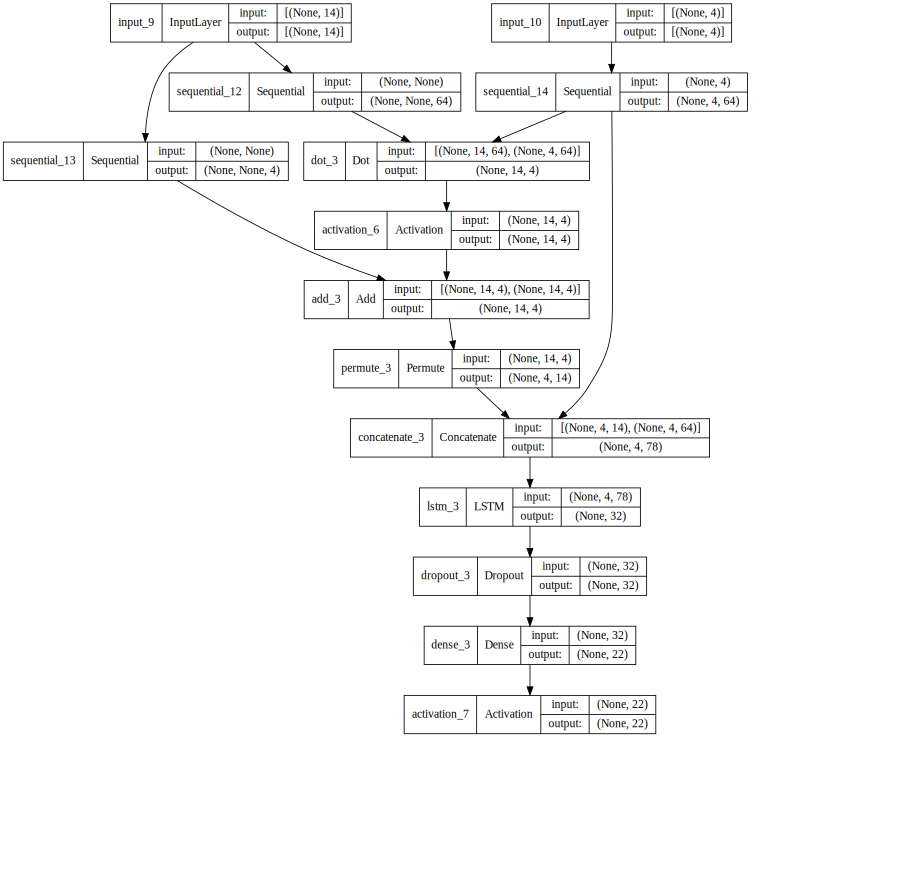

In [ ]:
from IPython.display import SVG

SVG(tf.keras.utils.model_to_dot(model,show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

Model summary

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 4)]          0           []                               
                                                                                                  
 sequential_12 (Sequential)     (None, None, 64)     1408        ['input_9[0][0]']                
                                                                                                  
 sequential_14 (Sequential)     (None, 4, 64)        1408        ['input_10[0][0]']               
                                                                                            

## 1.5 Training

In this section we start the training procedure with fitting the data to the designed model.

Epoch 1/10
  2/313 [..............................] - ETA: 18s - loss: 3.0818 - accuracy: 0.0312    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


313/313 [==============================] - 20s 65ms/step - loss: 1.9754 - accuracy: 0.1599 - val_loss: 1.8045 - val_accuracy: 0.1490
Epoch 2/10
313/313 [==============================] - 21s 66ms/step - loss: 1.8139 - accuracy: 0.1715 - val_loss: 1.7943 - val_accuracy: 0.1500
Epoch 3/10
313/313 [==============================] - 20s 65ms/step - loss: 1.7923 - accuracy: 0.1869 - val_loss: 1.7887 - val_accuracy: 0.1820
Epoch 4/10
313/313 [==============================] - 21s 66ms/step - loss: 1.7835 - accuracy: 0.2019 - val_loss: 1.7709 - val_accuracy: 0.2600
Epoch 5/10
313/313 [==============================] - 20s 64ms/step - loss: 1.7732 - accuracy: 0.2288 - val_loss: 1.7687 - val_accuracy: 0.2440
Epoch 6/10
313/313 [==============================] - 20s 64ms/step - loss: 1.7659 - accuracy: 0.2468 - val_loss: 1.7605 - val_accuracy: 0.2430
Epoch 7/10
313/313 [==============================] - 21s 66ms/step - loss: 1.7646 - accuracy: 0.2475 - val_loss: 1.7643 - val_accuracy: 0.2520
Epo

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


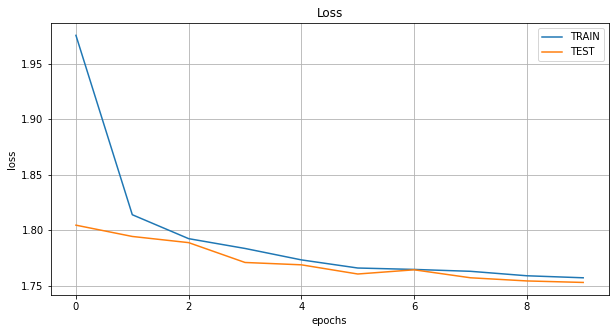

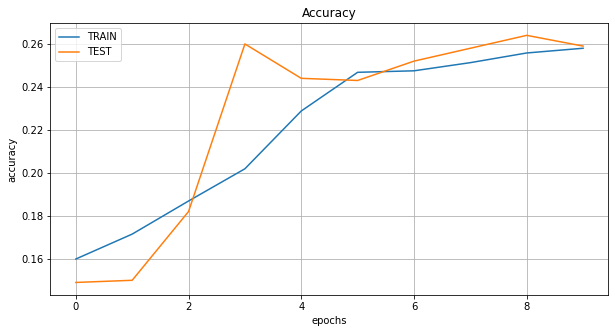

In [ ]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,
          validation_data=([inputs_test, queries_test], answers_test))
print()
print()

plot_loss(history,"Loss")
print('<*>' * 40)
plot_acc(history,"Accuracy")

model.save('model.h5')

## 1.6 Testing and Analysis

Now we need to actually make predictions and check the performance of our trained model with some examples:

In [ ]:
for i in range(0,10):
    current_inp = test_stories[2*i]
    current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
    current_prediction = model.predict([current_story, current_query])
    current_prediction = idx_word[np.argmax(current_prediction)]
    print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
    print("-----------------------------------------------------------------------------------------")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


John travelled to the hallway . Mary journeyed to the bathroom . Where is John ? | Prediction: bedroom | Ground Truth: hallway
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Where is Sandra ? | Prediction: bathroom | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Where is Sandra ? | Prediction: bathroom | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
Sandra travelled to the kitchen . Sandra travelled to the hallway . Where is Sandra ? | Prediction: kitchen | Ground Truth: garden
-----------------------------------------------------------------------------------------
Sandra travelled to the kitchen . Sandra travelled to the hallway . Where is Sandra ? | Prediction: kitchen | Ground Truth

## 1.7 Custom Inputs

You can even write your example and test it with your model to see how powerful it is:

In [ ]:
print('-------------------------------------------------------------------------------------------')
print('Custom User Queries (Make sure there are spaces before each word)')
while 1:
    print('-------------------------------------------------------------------------------------------')
    print('Please input a story')
    user_story_inp ='Mary went to the bathroom . Mary travelled to the office .'.split(' ')
    print('Please input a query')
    user_query_inp = 'Where is Mary ?'.split(' ')
    user_story, user_query, user_ans = vectorize_stories([[user_story_inp, user_query_inp, '.']], word_idx, story_maxlen, query_maxlen)
    user_prediction = model.predict([user_story, user_query])
    user_prediction = idx_word[np.argmax(user_prediction)]
    print('Result')
    print(' '.join(user_story_inp), ' '.join(user_query_inp), '| Prediction:', user_prediction)
    break

-------------------------------------------------------------------------------------------
Custom User Queries (Make sure there are spaces before each word)
-------------------------------------------------------------------------------------------
Please input a story
Please input a query
Result
Mary went to the bathroom . Mary travelled to the office . Where is Mary ? | Prediction: office


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
# some examples:
# Mary went to the bathroom . John moved to the hallway . Mary travelled to the office . # Where is Mary ?
# Sandra travelled to the office . John journeyed to the garden .

As you understood how the model trained, please tell us about the pros and cons of the proposed model. How can we improve it if we want to use it in realistic task ? 

$\color{red}{\text{Write your answer in document}}$



#  2. Hands on SSL

In [1]:
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Input, Dense, MaxPooling2D, Flatten
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import to_categorical

## 2.1 prepare data

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
unlabeld_index = np.ones(y_train.shape, np.bool)

N = 20
for i in range(10):
  idx = np.where(y_train == i)[0][:N]
  unlabeld_index[idx] = 0

In [4]:
x_unlabeld = x_train[np.where(unlabeld_index)[0], ...]

x_train = x_train[np.where(~unlabeld_index)[0], ...]
y_train = y_train[np.where(~unlabeld_index)[0], ...]

In [5]:
# examples of categorical crossentropy
cce = keras.losses.CategoricalCrossentropy()

# a labeled data from the second class
y_true = [[0, 1, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# an ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# another ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.1, 0.4, 0.3, 0.2]]
print(cce(y_true, y_pred).numpy())

0.051293306
0.0
0.0


In [6]:
print('x_train shape : {}'.format(x_train.shape))
print('x_unlabeld shape : {}'.format(x_unlabeld.shape))
print('y_train shape : {}'.format(y_train.shape))


x_train shape : (200, 32, 32, 3)
x_unlabeld shape : (49800, 32, 32, 3)
y_train shape : (200, 1)


### preprocessing

In [7]:
# normalization
X_unlabeld = x_unlabeld.astype('float32') / 255.0
X_train = x_train.astype('float32') / 255.0
X_test = x_test.astype('float32') / 255.0

# to categorical (one-hot encoding)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

print('X_unlabeld shape : {}'.format(X_unlabeld.shape))
print('X_train shape : {}'.format(X_train.shape))
print('Y_train shape : {}'.format(Y_train.shape))
print()
print('X_test shape : {}'.format(X_test.shape))
print('Y_test shape : {}'.format(Y_test.shape))


X_unlabeld shape : (49800, 32, 32, 3)
X_train shape : (200, 32, 32, 3)
Y_train shape : (200, 10)

X_test shape : (10000, 32, 32, 3)
Y_test shape : (10000, 10)


### Function helper For Ploting History 

In [8]:
!pip install plot-keras-history -q

In [9]:
from plot_keras_history import plot_history

def plot_model_history(history) -> None:
    # plt.figure(figsize=(5, 10))
    # plt.subplot(1, 2, 1)
    # plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    # plt.grid(True)
    # plt.ylabel('accuracy')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='best')
    
    # plt.subplot(1, 2, 2)
    # plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    # plt.grid(True)
    # plt.ylabel('loss')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='best')

    plot_history(history)

    return 


### define model

In [13]:
def create_model():
    model = Sequential()

    # convolution layers
    model.add(layers.Input(shape= (32, 32, 3)))
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model1 = create_model()
model1.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

### train and plot the history

In [14]:
history1 = model1.fit(X_train, Y_train, batch_size= 32, epochs=50, 
           validation_data=[X_test, Y_test])

Epoch 1/50
7/7 [==============================] - 5s 519ms/step - loss: 3.1505 - accuracy: 0.1300 - val_loss: 2.8042 - val_accuracy: 0.0957
Epoch 2/50
7/7 [==============================] - 2s 407ms/step - loss: 2.7937 - accuracy: 0.2400 - val_loss: 2.4787 - val_accuracy: 0.1088
Epoch 3/50
7/7 [==============================] - 2s 404ms/step - loss: 2.4797 - accuracy: 0.2500 - val_loss: 2.3378 - val_accuracy: 0.1264
Epoch 4/50
7/7 [==============================] - 2s 407ms/step - loss: 2.2613 - accuracy: 0.2900 - val_loss: 2.3144 - val_accuracy: 0.1335
Epoch 5/50
7/7 [==============================] - 3s 449ms/step - loss: 2.1949 - accuracy: 0.3050 - val_loss: 2.3050 - val_accuracy: 0.1358
Epoch 6/50
7/7 [==============================] - 3s 449ms/step - loss: 2.0747 - accuracy: 0.3700 - val_loss: 2.3886 - val_accuracy: 0.1286
Epoch 7/50
7/7 [==============================] - 2s 409ms/step - loss: 1.9699 - accuracy: 0.3950 - val_loss: 2.4909 - val_accuracy: 0.1356
Epoch 8/50
7/7 [====

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
model1.save('/content/drive/MyDrive/model1.h5')

In [18]:
model1 = keras.models.load_model('/content/drive/MyDrive/model1.h5')

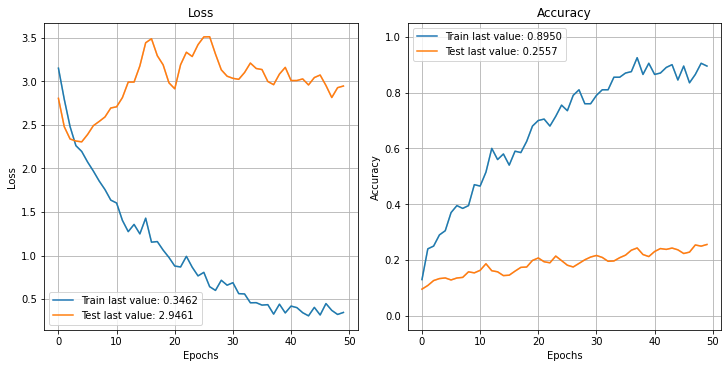

In [19]:
# plot model
plot_model_history(history=history1)

### Rotation Estimation


helper function for get intermediate layers of our model

In [14]:
def get_intermediate_layer():
    model = Sequential()

    # convolution layers
    model.add(layers.Input(shape= (32, 32, 3)))
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # # fully connected layers
    # model.add(Flatten())
    # model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    # model.add(Dense(10, activation='softmax'))
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Generate rotated data for estimation rotation which is same size as X_unlabeled data
in here we rotate our images in four ways which follow below rules:

0 --> no rotation 

1 --> 90 rotation

2 --> 180 rotation

3 --> 270 rotation

In [10]:
def generate_rotated_image():
    x_train_rotated = []
    y_train_rotated = []
    data_size = X_unlabeld.shape[0]
    
    degree = list(range(4))

    for i in range(data_size):
        deg = random.choices(degree, weights = [1, 2, 2, 2], k=1)[0]

        new_x = np.rot90(X_unlabeld[i], k = deg)
        new_y = np.zeros(4)
        new_y[deg] = 1

        x_train_rotated.append(new_x)
        y_train_rotated.append(new_y)

    return np.array(x_train_rotated), np.array(y_train_rotated)

x_train_rotated, y_train_rotated = generate_rotated_image()


In [11]:
print('x_train_rotated shape : {}'.format(x_train_rotated.shape))
print('y_train_rotated shape : {}'.format(y_train_rotated.shape))

x_train_rotated shape : (49800, 32, 32, 3)
y_train_rotated shape : (49800, 4)


visualize data which is rotated

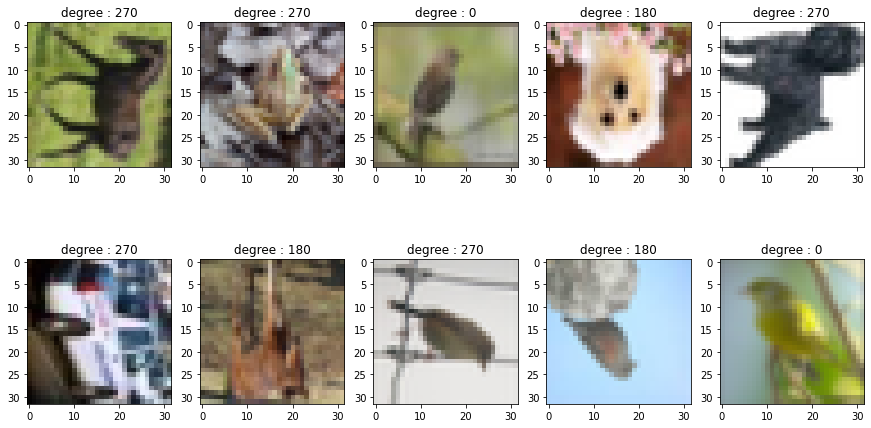

In [13]:
plt.figure(figsize=(15, 8))
for i in range(10):
    data = x_train_rotated[i + 331]
    deg = np.argmax(y_train_rotated[i + 331]) * 90
    plt.subplot(2, 5, i + 1)
    plt.title('degree : {}'.format(deg))
    plt.imshow(data)

plt.show()

Define model with similar convolution layer as we defined lately and just change the classifier and change the number of units in the last layer.
change it to 4 since we have 4 types of rotation.

In [19]:
model2 = get_intermediate_layer()

# change the classifier of our model
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(4, activation='softmax'))
model2.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_21 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_22 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

train model and save it into the drive.

In [20]:
history2 = model2.fit(x_train_rotated, 
                      y_train_rotated,
                      batch_size=128,
                      validation_split=0.2,
                      epochs=50)

model2.save('/content/drive/MyDrive/model2.h5')

Epoch 1/50
312/312 [==============================] - 13s 38ms/step - loss: 1.3143 - accuracy: 0.4836 - val_loss: 1.0491 - val_accuracy: 0.5344
Epoch 2/50
312/312 [==============================] - 11s 37ms/step - loss: 1.0066 - accuracy: 0.5802 - val_loss: 0.9181 - val_accuracy: 0.6223
Epoch 3/50
312/312 [==============================] - 11s 36ms/step - loss: 0.9254 - accuracy: 0.6142 - val_loss: 0.8719 - val_accuracy: 0.6420
Epoch 4/50
312/312 [==============================] - 11s 37ms/step - loss: 0.8723 - accuracy: 0.6445 - val_loss: 0.8545 - val_accuracy: 0.6540
Epoch 5/50
312/312 [==============================] - 11s 37ms/step - loss: 0.8309 - accuracy: 0.6608 - val_loss: 0.8637 - val_accuracy: 0.6592
Epoch 6/50
312/312 [==============================] - 11s 37ms/step - loss: 0.7964 - accuracy: 0.6781 - val_loss: 0.7621 - val_accuracy: 0.6961
Epoch 7/50
312/312 [==============================] - 12s 38ms/step - loss: 0.7664 - accuracy: 0.6916 - val_loss: 0.7207 - val_accuracy:

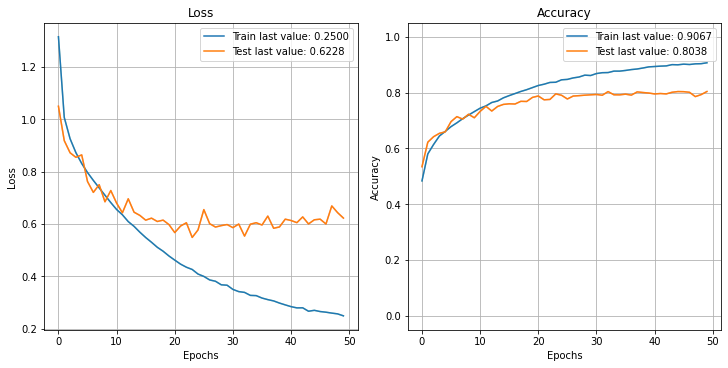

In [21]:
plot_model_history(history2)

#### change the last layer (classifier)


In [23]:
opt = keras.optimizers.Adam(learning_rate=0.0005)

new_classifier = Dense(10, activation='softmax')(model2.layers[-2].output)
model2_ver2 = keras.Model(model2.inputs, new_classifier)
model2_ver2.compile(optimizer=opt, loss= 'categorical_crossentropy', metrics=['accuracy'])
model2_ver2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18_input (InputLayer  [(None, 32, 32, 3)]      0         
 )                                                               
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_21 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_22 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                           

train model

In [24]:
history2_2 = model2_ver2.fit(X_train, Y_train, batch_size=32, validation_data=[X_test, Y_test], epochs=50)

Epoch 1/50
7/7 [==============================] - 5s 545ms/step - loss: 3.2015 - accuracy: 0.0950 - val_loss: 2.9422 - val_accuracy: 0.1196
Epoch 2/50
7/7 [==============================] - 3s 444ms/step - loss: 3.1703 - accuracy: 0.1150 - val_loss: 2.8055 - val_accuracy: 0.1306
Epoch 3/50
7/7 [==============================] - 2s 368ms/step - loss: 2.9180 - accuracy: 0.1700 - val_loss: 2.6655 - val_accuracy: 0.1458
Epoch 4/50
7/7 [==============================] - 3s 446ms/step - loss: 2.7017 - accuracy: 0.1650 - val_loss: 2.5494 - val_accuracy: 0.1614
Epoch 5/50
7/7 [==============================] - 2s 379ms/step - loss: 2.2986 - accuracy: 0.2750 - val_loss: 2.4606 - val_accuracy: 0.1777
Epoch 6/50
7/7 [==============================] - 3s 447ms/step - loss: 2.3994 - accuracy: 0.2400 - val_loss: 2.4078 - val_accuracy: 0.1911
Epoch 7/50
7/7 [==============================] - 2s 377ms/step - loss: 2.3911 - accuracy: 0.2550 - val_loss: 2.3589 - val_accuracy: 0.2025
Epoch 8/50
7/7 [====

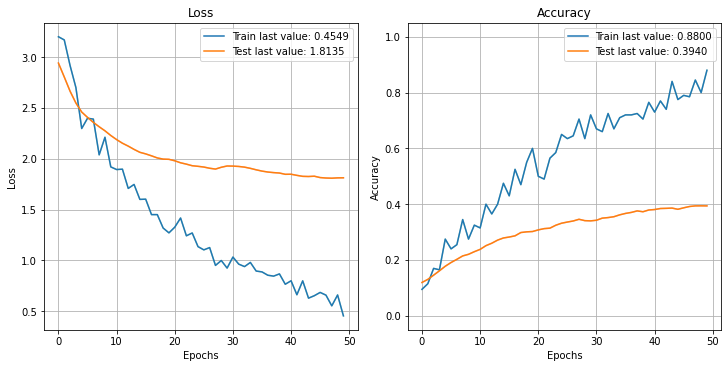

In [25]:
model2_ver2.save('/content/drive/MyDrive/model2_v2.h5')
plot_model_history(history2_2)

### 2 outputs

create data for parts. concatenate the x_train_rotated and X_train.

length of Y_train = 200

length of y_train_rotated = 49800

but we only have one input so we need to make Y_train and y_train_rotated same size and add 0 padding.

In [37]:
# concatenate
x_train_all = np.concatenate((X_train, x_train_rotated), axis=0)

# y_classifier
y1 = np.concatenate((Y_train, np.zeros(shape=(y_train_rotated.shape[0], 10))), axis=0)

# y_rotate_estimation
y2 = np.concatenate(( np.zeros(shape= (Y_train.shape[0], 4) ) , y_train_rotated), axis=0)

# shuffle the data so the model dosen't become bais on data
X_train_all, Y1, Y2 = shuffle(x_train_all, y1, y2, random_state=42)

y_train_all = [Y1, Y2]

print('x_train_all shape : {}'.format(X_train_all.shape))
print('y_train_classifier shape : {}'.format(Y1.shape))
print('y_train_rotate_estimation shape : {}'.format(Y2.shape))


x_train_all shape : (50000, 32, 32, 3)
y_train_classifier shape : (50000, 10)
y_train_rotate_estimation shape : (50000, 4)


#### generate test data for evaluation the model.

In [38]:
# rotate test data
x_test_rotated = []
y_test_rotated = []
data_size = X_test.shape[0]

degree = list(range(3))

for i in range(data_size):
    deg = random.choices(degree, weights = [1, 1, 1], k=1)[0] + 1

    new_x = np.rot90(X_test[i], k = deg)
    new_y = np.zeros(4)
    new_y[deg] = 1

    x_test_rotated.append(new_x)
    y_test_rotated.append(new_y)

x_test_rotated = np.array(x_test_rotated)
y_test_rotated = np.array(y_test_rotated)
print('x_test_rotated shape : {}'.format(x_test_rotated.shape))
print('y_test_rotated shape : {}'.format(y_test_rotated.shape))




x_test_rotated shape : (10000, 32, 32, 3)
y_test_rotated shape : (10000, 4)


In [39]:
x_test_all = np.concatenate((X_test, x_test_rotated), axis=0)

# y_classifier test
y1_test = np.concatenate( (Y_test, np.zeros(shape=(y_test_rotated.shape[0], 10))) , axis=0)

# y_rotation test
y2_test = np.concatenate( ( np.zeros(shape = (Y_test.shape[0], 4) ) , y_test_rotated), axis=0)

print('x_test_all shape : {}'.format(x_test_all.shape))
print('y_classifier_test shape : {}'.format(y1_test.shape))
print('y_rotation_test shape : {}'.format(y2_test.shape))


x_test_all shape : (20000, 32, 32, 3)
y_classifier_test shape : (20000, 10)
y_rotation_test shape : (20000, 4)


#### define model

In [40]:
def get_final_model():
    model = get_intermediate_layer()
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # classifie layer
    classifier = Dense(10, activation='softmax', name='type_classifier')(model.layers[-1].output)

    # rotation_estimation layer
    rotation = Dense(4, activation='softmax', name='rotation_classifier')(model.layers[-1].output)
    
    f_model = keras.Model(inputs=model.input, outputs = [classifier, rotation])
    print(f_model.summary())
    return f_model

model3 = get_final_model()
    

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_24_input (InputLayer)   [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 32, 32, 32)   896         ['conv2d_24_input[0][0]']        
                                                                                                  
 batch_normalization_28 (BatchN  (None, 32, 32, 32)  128         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_25 (Conv2D)             (None, 32, 32, 32)   9248        ['batch_normalization_28[0]

create helper function for compile and fit the model.


In [41]:
def compile_fit_model(model, loss_weights : dict):
    opt = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=opt,
                  loss = {
                      'type_classifier' : 'categorical_crossentropy',
                      'rotation_classifier': 'categorical_crossentropy'
                  },
                  loss_weights = loss_weights,
                  metrics= {
                      'type_classifier' : 'accuracy',
                      'rotation_classifier': 'accuracy' 
                  })
    
    return model.fit(X_train_all,
              [Y1, Y2], validation_data = (x_test_all, [y1_test, y2_test]), batch_size=128, epochs=30)
    

#### As it mentioned in the document we create we change the loss weights.

In [42]:
loss_weights1 = {
    'type_classifier' : 4,
    'rotation_classifier': 2
}

his3_1 = compile_fit_model(model3, loss_weights1)

Epoch 1/30
391/391 [==============================] - 18s 42ms/step - loss: 2.8674 - type_classifier_loss: 0.0115 - rotation_classifier_loss: 1.4107 - type_classifier_accuracy: 0.1030 - rotation_classifier_accuracy: 0.4193 - val_loss: 5.7105 - val_type_classifier_loss: 1.1654 - val_rotation_classifier_loss: 0.5245 - val_type_classifier_accuracy: 0.0606 - val_rotation_classifier_accuracy: 0.3660
Epoch 2/30
391/391 [==============================] - 16s 40ms/step - loss: 2.7451 - type_classifier_loss: 0.0117 - rotation_classifier_loss: 1.3492 - type_classifier_accuracy: 0.1003 - rotation_classifier_accuracy: 0.3833 - val_loss: 6.1428 - val_type_classifier_loss: 1.2152 - val_rotation_classifier_loss: 0.6409 - val_type_classifier_accuracy: 0.0584 - val_rotation_classifier_accuracy: 0.1683
Epoch 3/30
391/391 [==============================] - 16s 40ms/step - loss: 2.6366 - type_classifier_loss: 0.0122 - rotation_classifier_loss: 1.2939 - type_classifier_accuracy: 0.0996 - rotation_classifie

plot the history of the model.

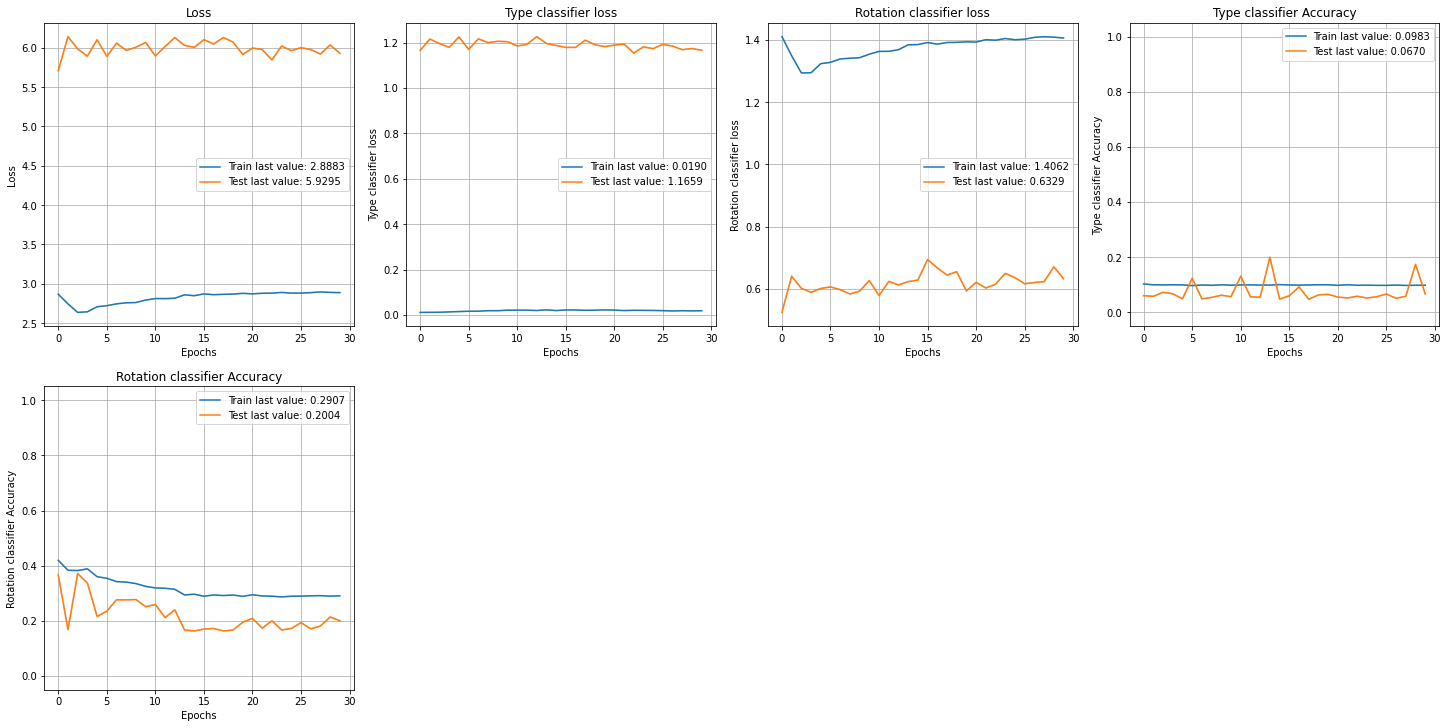

In [43]:
plot_model_history(his3_1)

#### loss weights 2

In [44]:
model3_1 = get_final_model()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_30_input (InputLayer)   [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_30 (Conv2D)             (None, 32, 32, 32)   896         ['conv2d_30_input[0][0]']        
                                                                                                  
 batch_normalization_35 (BatchN  (None, 32, 32, 32)  128         ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_31 (Conv2D)             (None, 32, 32, 32)   9248        ['batch_normalization_35[0]

In [45]:
loss_weights2 = {
    'type_classifier' : 1,
    'rotation_classifier': 4
}

his3_1 = compile_fit_model(model3_1, loss_weights2)

Epoch 1/30
391/391 [==============================] - 18s 42ms/step - loss: 5.2505 - type_classifier_loss: 0.0100 - rotation_classifier_loss: 1.3101 - type_classifier_accuracy: 0.0658 - rotation_classifier_accuracy: 0.4721 - val_loss: 3.0668 - val_type_classifier_loss: 1.1577 - val_rotation_classifier_loss: 0.4773 - val_type_classifier_accuracy: 0.0411 - val_rotation_classifier_accuracy: 0.3841
Epoch 2/30
391/391 [==============================] - 16s 40ms/step - loss: 4.3758 - type_classifier_loss: 0.0101 - rotation_classifier_loss: 1.0914 - type_classifier_accuracy: 0.0529 - rotation_classifier_accuracy: 0.5414 - val_loss: 3.0826 - val_type_classifier_loss: 1.1824 - val_rotation_classifier_loss: 0.4750 - val_type_classifier_accuracy: 0.0607 - val_rotation_classifier_accuracy: 0.4660
Epoch 3/30
391/391 [==============================] - 16s 40ms/step - loss: 4.4643 - type_classifier_loss: 0.0111 - rotation_classifier_loss: 1.1133 - type_classifier_accuracy: 0.0696 - rotation_classifie

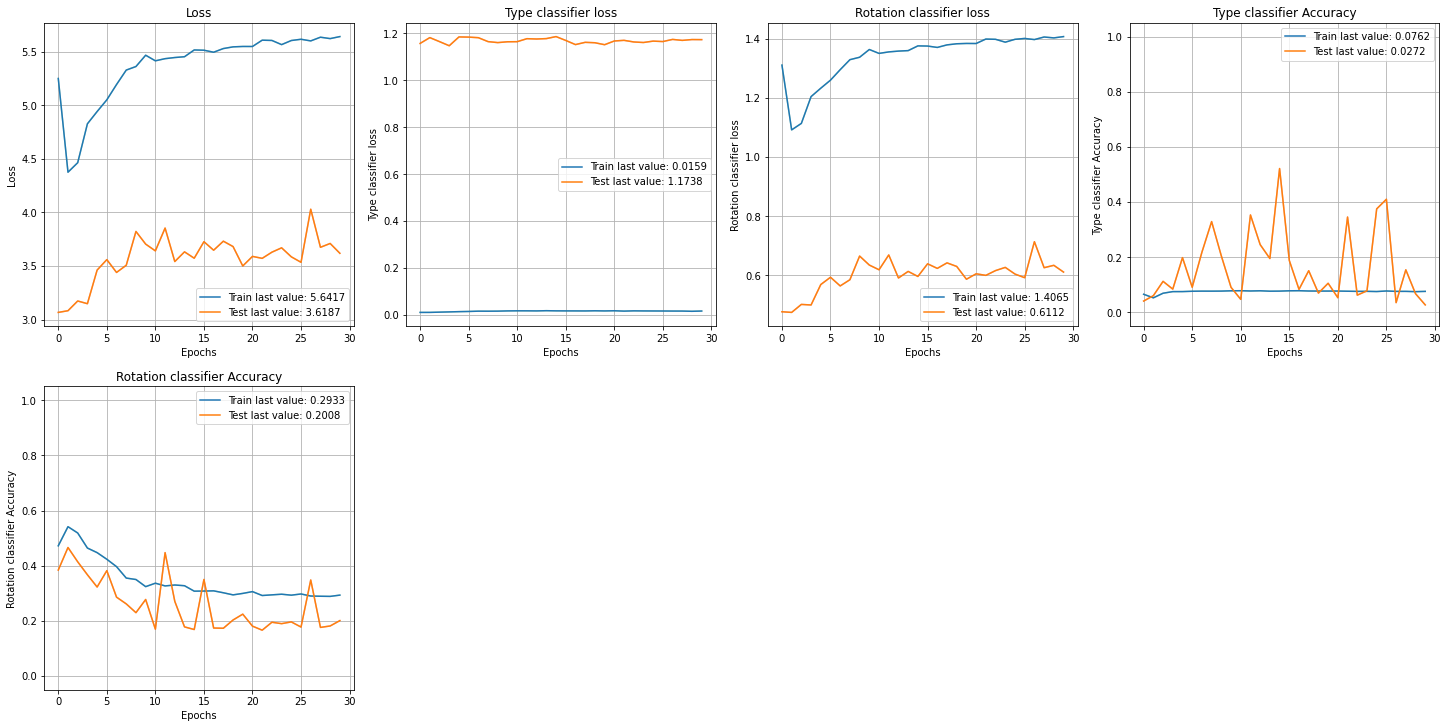

In [46]:
plot_model_history(his3_1)

#### third loss-weights

In [28]:
loss_weights3 = {
    'type_classifier' : 0.05,
    'rotation_classifier': 1
}
model3_3 = get_final_model()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_18_input (InputLayer)   [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 32)   896         ['conv2d_18_input[0][0]']        
                                                                                                  
 batch_normalization_21 (BatchN  (None, 32, 32, 32)  128         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 32, 32)   9248        ['batch_normalization_21[0]

In [30]:
his_3_3 = compile_fit_model(model3_3, loss_weights3)

Epoch 1/30
391/391 [==============================] - 73s 42ms/step - loss: 1.7339 - type_classifier_loss: 0.0117 - rotation_classifier_loss: 1.7333 - type_classifier_accuracy: 0.1379 - rotation_classifier_accuracy: 0.2694 - val_loss: 0.6961 - val_type_classifier_loss: 1.1642 - val_rotation_classifier_loss: 0.6379 - val_type_classifier_accuracy: 0.3083 - val_rotation_classifier_accuracy: 0.1682
Epoch 2/30
391/391 [==============================] - 16s 40ms/step - loss: 1.4324 - type_classifier_loss: 0.0095 - rotation_classifier_loss: 1.4319 - type_classifier_accuracy: 0.2427 - rotation_classifier_accuracy: 0.2810 - val_loss: 0.6907 - val_type_classifier_loss: 1.1577 - val_rotation_classifier_loss: 0.6328 - val_type_classifier_accuracy: 0.4577 - val_rotation_classifier_accuracy: 0.1675
Epoch 3/30
391/391 [==============================] - 17s 42ms/step - loss: 1.3829 - type_classifier_loss: 0.0095 - rotation_classifier_loss: 1.3824 - type_classifier_accuracy: 0.2738 - rotation_classifie

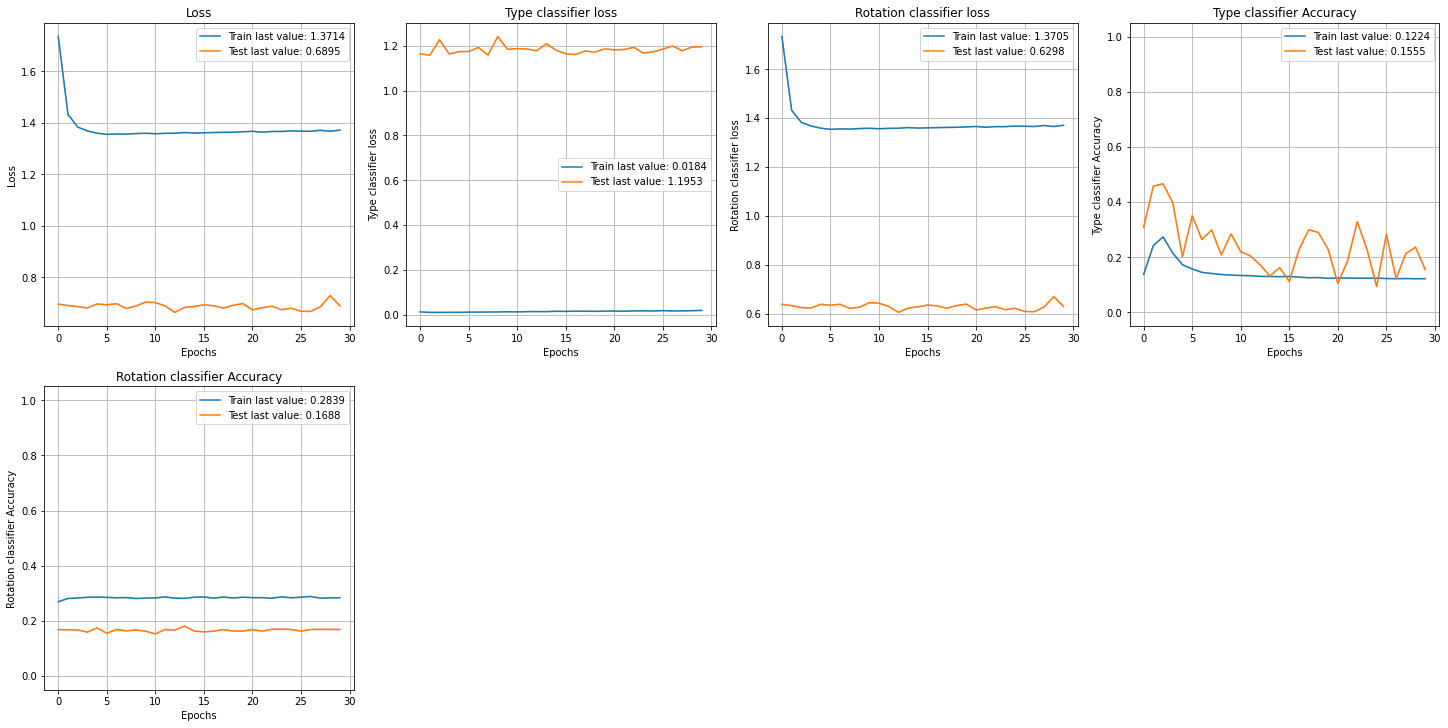

In [31]:
plot_model_history(his_3_3)